## NGS processing pipeline for RNAI libraries
#### V. Pinheiro - v. 0.1 (10/23)

A lot of information is given on the equivalent files set up for LoopI. Here, the code is set up a little different, to facilitate the computation.

In [2]:
## Packages needed to run the data clean up
using DataFrames
using CSV
using FASTX
using BioAlignments
using BioSequences
using Random
using StatsBase
using StatsPlots
using Combinatorics
using ViennaRNA
using Unitful
using Clustering
using PlotRNA
using DelimitedFiles


In [3]:
## All functions are summarised here for clarity and code efficiency

# Load FASTA file as an Array of String
function load_fasta_file(file_name::String)
    R0 = []
    reader = FASTA.Reader(open(file_name, "r"))
    for record in reader
        push!(R0, convert(String, FASTA.sequence(record)))
    end
    close(reader)
    return R0
end

# Uses string patterns to isolate LoopI relevant sequences
function isolate_hairpin(File::String, upstream::String, downstream::String)
    full_seq = []
    all_seq = load_fasta_file(File)

    for n = 1:size(all_seq, 1)
        if occursin(upstream, all_seq[n]) && occursin(downstream, all_seq[n]) # looks for sequences that have both sequences
            edge1 = findfirst(upstream, all_seq[n])[end] # finds the beginning of stem 1
            edge2 = findfirst(downstream, all_seq[n])[1] # finds the end of stem 1
            # the processing above must always be checked to ensure single base duplication or
            # deletion is not being accidentally introduced 
    
            new_seq = all_seq[n][edge1:edge2]
            if new_seq != ""
                push!(full_seq, new_seq) # pushes non-empty sequences into a set
            end
        end
    end

    return full_seq
end    

# used to convert individual NGS reads into a table containing the counts of individual sequences
function instance_to_count(library, wild_type)
    # Converts the data to a dictionary to allow de-duplication
    NGS_processing = Dict{String, Int64}()
    NGS_clean = DataFrame([[],[],[],[], []],["Sequence_number", "LoopI", "Loop_length", "Count", "WT"])

    for i = 1: size(library, 1) # de-duplication process
        if haskey(NGS_processing, library[i])
            NGS_processing[library[i]] += 1
        else
            NGS_processing[library[i]] = 1
        end
    end

    # Remaps the dictionary to a DataFrame for subsequent analysis
    for (key, value) ∈ NGS_processing   # converts dictionary to DataFrame
        entry = DataFrame([[0], [key], [length(key)], [value], ["false"]], ["Sequence_number", "LoopI", "Loop_length", "Count", "WT"])
        append!(NGS_clean, entry)
    end
    
    sort!(NGS_clean, :Count, rev=true)
    
    ## Identifies the WT sequence
    for n = 1:size(NGS_clean, 1)
    NGS_clean.Sequence_number[n] = n
        if NGS_clean.LoopI[n] == wild_type
            NGS_clean.WT[n] = "WT"
        end
    end
    
    return NGS_clean
end

# Generates all possible variants within a given Hamming distance
function hamming(sequence::String, distance::Int)
    output = [] # creates a space for output
    new_entry = []
    bases = ['A', 'C', 'G', 'T']
   

    # calculating all sequences to be searched
    positions = collect(combinations(collect(UnitRange(1, length(sequence))), distance)) # generates all the positions
    variants = collect(multiset_permutations(bases, [distance,distance,distance,distance], distance)) # generates all the nucleobase variants

    for i = 1: size(positions, 1)
        for j = 1: size(variants, 1)
            new_entry = collect(sequence)
            for x = 1: distance
                new_entry[positions[i][x]] = variants[j][x]
            end
            push!(output, join(new_entry))
        end
    end


    #return output
    return unique(output)
end

# Takes the processed NGS DataFrame and uses a frequency-based algorithm to remove possible sequencing errors
# and the wild-type from the DataFrame
function clustering_errors(start_library, wildtype, subst_rate)
    for i = 1: size(start_library, 1)
        if start_library.WT[i] == "WT"
            seed_seq = start_library.Sequence_number[i]
            close_neighbour = hamming(wildtype, 1)
        
            for j = (seed_seq+1): size(start_library, 1)
                if start_library.LoopI[j] ∈ close_neighbour && start_library.Count[j] <= (subst_rate * start_library.Count[seed_seq]) 
                    start_library.WT[j] = "counted"
                    start_library.Count[seed_seq] += start_library.Count[j]
                end
            end
        
        elseif start_library.WT[i] == "false" && start_library.Count[i] * subst_rate >= 1.0
            seed_seq = start_library.Sequence_number[i]
            close_neighbour = hamming(start_library.LoopI[i], 1)
        
            for j = seed_seq+1:size(start_library, 1)
                if start_library.LoopI[j] ∈ close_neighbour && start_library.Count[j] <= (subst_rate * start_library.Count[seed_seq]) 
                    start_library.WT[j] = "counted"
                    start_library.Count[seed_seq] += start_library.Count[j]
                end
            end
        end
    end

    Clustered = filter(:WT => x -> x == "false", start_library)
    return Clustered
end  
    
## All functions are summarised here for clarity and code efficiency

# generating structural data 
function rna_details(dataframe::DataFrame, downstream::String)
    Loop_structure = DataFrame([String[],String[], Float32[], Float32[]],["LoopI", "MFE_structure","MFE_energy","Mbp_dist"])
    for n = 1: size(dataframe, 1)
        new_loop = dataframe.LoopI[n] * downstream
        new_fold = FoldCompound(new_loop; temperature=37u"°C", uniq_ML=false, circular=false);
        partfn(new_fold)
        new_mfe = mfe(new_fold)
        new_bpdis = mean_bp_distance(new_fold)
        
        push!(Loop_structure, (dataframe.LoopI[n], new_mfe[1], ustrip(new_mfe[2]), new_bpdis))
        finalize(new_fold)
    end
    dataframe = innerjoin(dataframe, Loop_structure, on = :LoopI);
    insertcols!(dataframe, :Seq_Cluster => 0, :Str_Cluster => 0)
    return dataframe
end
    
## All functions are summarised here for clarity and code efficiency

## Takes the previously created Dataframe and remaps it to a structure dataframe
function extracting_structures(dataset)
    
    zoo_struct = Dict{String, Int64}()
    zoo_structure_df = DataFrame([[],[],[],[]],["Str_number","MFE_structure", "Total_Count", "Str_Cluster"])
    str = 1    

    for i = 1: size(dataset, 1)
        key = dataset.MFE_structure[i]
        value = dataset.Count[i]
    
        if key ∈ keys(zoo_struct)
            zoo_struct[key] += value
        else
            zoo_struct[key] = value
        end
    end
    
    for (key, value) in zoo_struct
        new_entry = DataFrame([[str], [key],[value],[0]], ["Str_number","MFE_structure", "Total_Count", "Str_Cluster"])
        append!(zoo_structure_df, new_entry)
        str += 1
    end
    sort!(zoo_structure_df, :Total_Count, rev=true)
    
    return zoo_structure_df
end


## Function to identify and isolate only the most frequent structures
function cdf_cutoff(dataset, cutoff)
    total_count = sum(dataset.Total_Count)
    cdfplot = zeros(size(dataset, 1), 1)
    for n = 1: size(cdfplot,1)
        if n == 1
            cdfplot[1] = dataset.Total_Count[1]
        else
            cdfplot[n] = cdfplot[n-1] + dataset.Total_Count[n]
        end
    end
    cdfplot = cdfplot/total_count

    limit = 0
    count = 0
    for n = 1: 1: size(cdfplot,1)
        if cdfplot[n] > cutoff && count == 0
            limit = n
            count = 1
        end
    end

    p1 = plot(cdfplot, labels=false)
    vline!([limit], labels="$(cutoff*100)% cut-off", color=:grey, lw=2)
    return (plot(p1), limit)
end


# Variation of the original function but to correct the indexes for generation and to take the modified input
function isolate_hairpin2(all_seq::Vector, upstream::String, downstream::String)
    full_seq = []

    for n = 1:size(all_seq, 1)
        if occursin(upstream, all_seq[n]) && occursin(downstream, all_seq[n]) # looks for sequences that have both sequences
            edge1 = findfirst(upstream, all_seq[n])[end]#+1 # finds the beginning of stem 1
            edge2 = findfirst(downstream, all_seq[n])[1]#-1 # finds the end of stem 1
    
            new_seq = all_seq[n][edge1:edge2]
            if new_seq != ""
                push!(full_seq, new_seq) # pushes non-empty sequences into a set
            end
        end
    end

    return full_seq
end 
    
# generating structural data 
function rna_details(dataframe::DataFrame, downstream::String, upstream::String)
    Loop_structure = DataFrame([String[],String[], Float32[], Float32[]],["LoopI", "MFE_structure","MFE_energy","Mbp_dist"])
    for n = 1: size(dataframe, 1)
        new_loop = upstream* dataframe.LoopI[n] * downstream
        new_fold = FoldCompound(new_loop; temperature=37u"°C", uniq_ML=false, circular=false);
        partfn(new_fold)
        new_mfe = mfe(new_fold)
        new_bpdis = mean_bp_distance(new_fold)
        
        push!(Loop_structure, (dataframe.LoopI[n], new_mfe[1], ustrip(new_mfe[2]), new_bpdis))
        finalize(new_fold)
    end
    dataframe = innerjoin(dataframe, Loop_structure, on = :LoopI);
    insertcols!(dataframe, :Seq_Cluster => 0, :Str_Cluster => 0)
    return dataframe
end

rna_details (generic function with 2 methods)

In [4]:
## Loop3 parameters
upstream = "CTCTTTTTCCGAA"
downstream = "AATACTGT"
wildtype = "GGTAACTGGCTTCAGCAGAGCGCAGATACCA"

file_name = "Large_Loop3.fasta"

lib_pre = instance_to_count(isolate_hairpin(file_name, upstream, downstream),wildtype);
lib_filtered = clustering_errors(lib_pre, wildtype, 0.005);

true

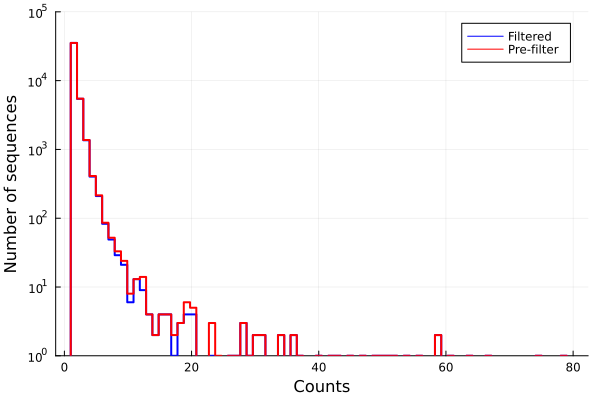

In [5]:
## Looking at the impact of the filtering
his_range = range(1, 80, length=81)
stephist(lib_filtered.Count, yaxis=(:log10, (1, 100000)), bins = his_range,
    ylabel="Number of sequences", lw=2, color=:blue, labels="Filtered")
stephist!(lib_pre.Count, yaxis=(:log10, (1, 100000)), bins = his_range, 
    ylabel="Number of sequences", xlabel="Counts", lw=2, color=:red, labels="Pre-filter")

## Adding RNA structural data to the isolated sequences


In [8]:
## Loading the folding parameters for ViennaRNA
ViennaRNA.params_load_RNA_Langdon2018()

## Sequence missing from LoopIII to generate the full-length RNAI
upstream_RNAI = "ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGCTACCAACTCTTTTTCCGAA"
downstream_RNAI = "AATACTGT"

true

In [7]:
## Adding structural information to the dataframe
lib_analysis = rna_details(lib_filtered, downstream_RNAI, upstream_RNAI)

Row,Sequence_number,LoopI,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Seq_Cluster,Str_Cluster
,Any,Any,Any,Any,Any,String,Float32,Float32,Int64,Int64
1,2,GGTAACTGGCTGAGCGCAGATACCA,25,2736,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((...)).))).)))).........,-36.6,10.3369,0,0
2,3,GGTAACTGGCTAGAGCGCAGATACCA,26,419,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((....)).))).)))).........,-38.5,4.88367,0,0
3,4,GGTAACTGGCTCAGAGCGCAGATACCA,27,364,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((.....)).))).)))).........,-38.5,5.19461,0,0
4,5,GGTAACTGGCTCGGAGCGCAGATACCA,27,151,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((.....)).))).)))).........,-38.5,5.58842,0,0
5,6,GGTAACTGGCTGCGAGCGCAGATACCA,27,138,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((..(((((((....))))...)))..))))..,-40.5,5.62198,0,0
6,7,GGTAACTGGCTGTGGAGCGCAGATACCA,28,131,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.((((((....))).))).)))).........,-40.0,5.93097,0,0
7,8,GGTAACTGGCTGGAGCGCAGATACCA,26,127,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((....)).))).)))).........,-38.5,5.05286,0,0
8,9,GGTAACTGGCTGCGCAGATACCA,23,103,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((..(((...........)))..))))..,-35.9,9.6051,0,0
9,10,GGTAACTGGCTAGTGGAGCGCAGATACCA,29,88,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.((((((.....))).))).)))).........,-40.0,4.51703,0,0


In [8]:
save_name = "Processed_" * file_name[1:end-6] * ".csv"

## Saving results
CSV.write(save_name, lib_analysis)

## Opening saved results
#lib_analysis = CSV.read(save_name, DataFrame);


"Processed_Large_Loop3.csv"

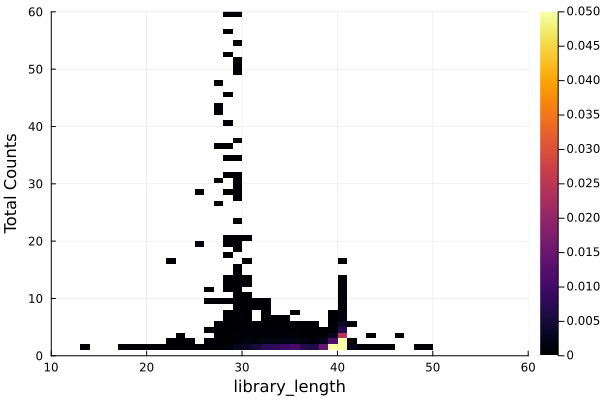

In [9]:
## Looking at the relationship between the frequency of a sequence in the population and its length
hisy_range = range(0, 60, length=61)
hisx_range = range(10, 60, length=51)
histogram2d(lib_analysis.Loop_length, lib_analysis.Count, xlabel = "library_length", ylabel = "Total Counts",
    bins = (hisx_range,hisy_range), show_empty_bins=false, normalize=:pdf, clim=(0,0.05))

In [11]:
libAnalysisClean = filter(:Loop_length => n -> n == 40 || n == 39 , lib_analysis)

Row,Sequence_number,LoopI,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Seq_Cluster,Str_Cluster
,Any,Any,Any,Any,Any,String,Float32,Float32,Int64,Int64
1,71,GGTAACTGGCTTTATCTATGTCGTGTGAGCGCAGATACCA,40,16,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((...(......)...)))).))).)))).........,-42.0,5.58708,0,0
2,81,GGTAACTGGCTACTCTGATGGAAATGGAGCGCAGATACCA,40,13,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((..(............)..)).))).)))).........,-40.3,9.70273,0,0
3,82,GGTAACTGGCTAACATCTTGACCTATGAGCGCAGATACCA,40,12,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.((((((................))).))).)))).........,-40.0,5.79525,0,0
4,86,GGTAACTGGCTAAATGGGTATTGCATGAGCGCAGATACCA,40,12,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.((((((..(((.......))).))).))).)))).........,-40.6,6.46942,0,0
5,96,GGTAACTGGCTCTTGTGGCATTGTCTGAGCGCAGATACCA,40,11,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((..............)))).))).)))).........,-44.1,4.81044,0,0
6,97,GGTAACTGGCTGGTGTCGTGGCGTCGGAGCGCAGATACCA,40,11,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))............(((((((...((((....)))).)))))))........,-41.9,14.4112,0,0
7,100,GGTAACTGGCTGTGTACGTGACTTACGAGCGCAGATACCA,40,11,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((..(((((((((.(((.....))).))))))...)))..))))..,-43.8,6.74481,0,0
8,101,GGTAACTGGCTATATGATTCGACTGCGAGCGCAGATACCA,40,11,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.((((((................))).))).)))).........,-40.0,12.2983,0,0
9,104,GGTAACTGGCTCCGGTTTTTCGTCTCGAGCGCAGATACCA,40,11,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.((........)).)))).))).)))).........,-43.7,5.8987,0,0


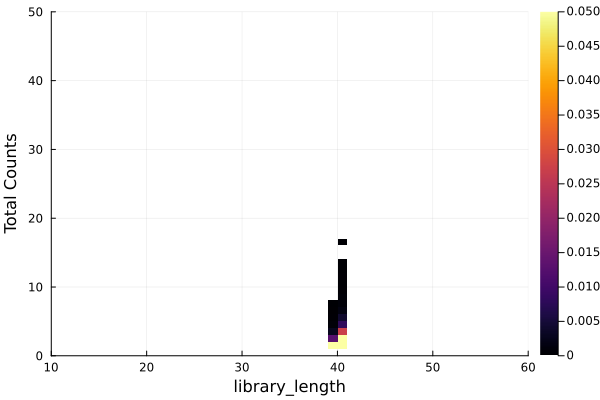

In [12]:
## Looking at the impact of the filtering
hisy_range = range(0, 50, length=51)
hisx_range = range(10, 60, length=51)
histogram2d(libAnalysisClean.Loop_length, libAnalysisClean.Count, xlabel = "library_length", ylabel = "Total Counts",
    bins = (hisx_range,hisy_range), show_empty_bins=false, normalize=:pdf, clim=(0,0.05))

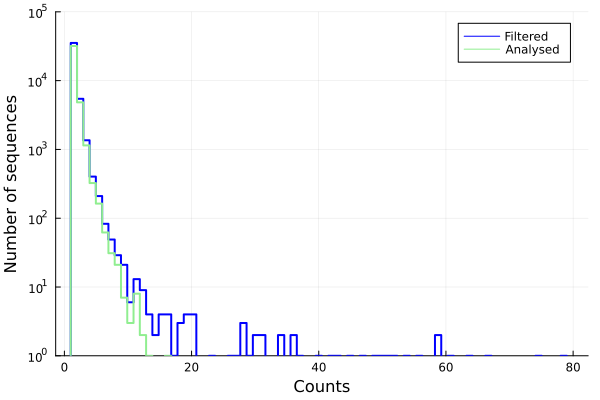

In [13]:
## Looking at the impact of the filtering by length on the population
his_range = range(1, 80, length=81)
stephist(lib_filtered.Count, yaxis=(:log10, (1, 100000)), bins = his_range,
    ylabel="Number of sequences", lw=2, color=:blue, labels="Filtered")
stephist!(libAnalysisClean.Count, yaxis=(:log10, (1, 100000)), bins = his_range, 
    ylabel="Number of sequences", xlabel="Counts", lw=2, color=:lightgreen, labels="Analysed")

In [14]:
save_name = "AnalysisReady_" * file_name[1:end-6] * ".csv"

## Saving results
CSV.write(save_name, libAnalysisClean)

## Opening saved results
#libAnalysisClean = CSV.read(save_name, DataFrame);


"AnalysisReady_Large_Loop3.csv"

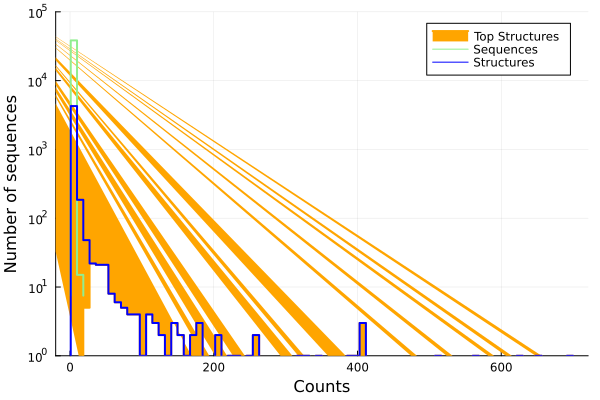

In [15]:
str4Analysis = extracting_structures(libAnalysisClean)
(plot_cdf,cutoffStr) = cdf_cutoff(str4Analysis, 0.75)

## Looking at the sampling of the population
his_range = range(1, 700, length=81)
stephist(str4Analysis.Total_Count[1:cutoffStr], yaxis=(:log10, (1, 100000)), bins = his_range, 
    ylabel="Number of sequences", xlabel="Counts", ma=0.2, lw=2, color=:orange, labels="Top Structures", fill=true)
stephist!(libAnalysisClean.Count, yaxis=(:log10, (1, 100000)), bins = his_range, 
    ylabel="Number of sequences", xlabel="Counts", lw=2, color=:lightgreen, labels="Sequences")
stephist!(str4Analysis.Total_Count, yaxis=(:log10, (1, 100000)), bins = his_range,
    ylabel="Number of sequences", lw=2, color=:blue, labels="Structures")

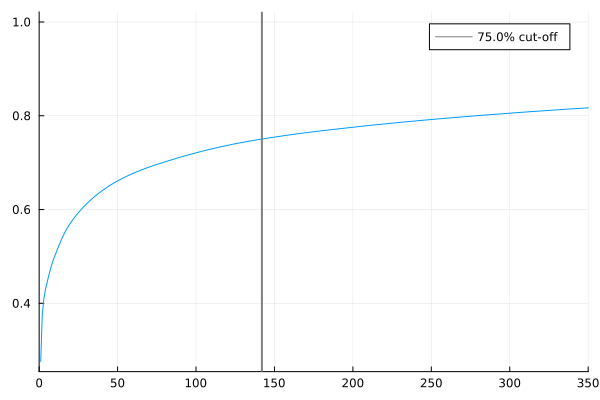

In [16]:
p1 = plot(plot_cdf, xaxis=[0,350])

In [69]:
## Creating a sample library with two lengths

## Loop3 long_library design
upstream_lib = "CTCTTTTTCCGAAGGTAACTGGCT"
downstream_lib = "GAGCGCAGATACCAAATACTGT"

numberOfSequences = 2e5
randomLibrary = []

#total number of samples in the original library
total = sum(libAnalysisClean.Count)
subset_lib = filter(:Loop_length => n -> n == 39, libAnalysisClean)
subset = sum(subset_lib.Count) # Identifying the number of sequences in the subset

subSize = Int64(floor((subset/total)*numberOfSequences)) # splitting the resulting library

for sequence = 1:(numberOfSequences - subSize)
    insert = rand(["A", "C", "G", "T"], 15)
    sequence = ""
    for base in insert
        sequence = sequence * base
    end
    libraryElement = upstream_lib * sequence * downstream_lib
    push!(randomLibrary, libraryElement)
end
for sequence = 1:subSize
    insert = rand(["A", "C", "G", "T"], 14)
    sequence = ""
    for base in insert
        sequence = sequence * base
    end
    libraryElement = upstream_lib * sequence * downstream_lib
    push!(randomLibrary, libraryElement)
end

In [70]:
sampledDataset = instance_to_count(isolate_hairpin2(randomLibrary, upstream, downstream), wildtype)
sort!(sampledDataset, :Count, rev=true)

Row,Sequence_number,LoopI,Loop_length,Count,WT
,Any,Any,Any,Any,Any
1,1,GGTAACTGGCTTGAGTGGCATGACAAGAGCGCAGATACCA,40,2,false
2,2,GGTAACTGGCTATTATGTACCCGACGAGCGCAGATACCA,39,2,false
3,3,GGTAACTGGCTATGGTTGGCCCTCGCGAGCGCAGATACCA,40,2,false
4,4,GGTAACTGGCTCGATGTAGAAGGTGGGAGCGCAGATACCA,40,2,false
5,5,GGTAACTGGCTTAAATCCCCAGATTTGAGCGCAGATACCA,40,2,false
6,6,GGTAACTGGCTAGTAGCCTAGCACATGAGCGCAGATACCA,40,2,false
7,7,GGTAACTGGCTGCTGCTTCATGACCCGAGCGCAGATACCA,40,2,false
8,8,GGTAACTGGCTCTAAAAAAATAACTTGAGCGCAGATACCA,40,2,false
9,9,GGTAACTGGCTTGTCTCCAGTGTACTGAGCGCAGATACCA,40,2,false


In [71]:
## Adding structural information to the dataframe - long
sampledDataset = rna_details(sampledDataset, downstream_RNAI, upstream_RNAI)

Row,Sequence_number,LoopI,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Seq_Cluster,Str_Cluster
,Any,Any,Any,Any,Any,String,Float32,Float32,Int64,Int64
1,1,GGTAACTGGCTTGAGTGGCATGACAAGAGCGCAGATACCA,40,2,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((..((......))..)))).))).)))).........,-42.9,5.42399,0,0
2,2,GGTAACTGGCTATTATGTACCCGACGAGCGCAGATACCA,39,2,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.((((((...............))).))).)))).........,-40.0,6.23394,0,0
3,3,GGTAACTGGCTATGGTTGGCCCTCGCGAGCGCAGATACCA,40,2,false,......((((((((((.....))))))))))((((((((((..(((((.......)))))..)))).((....))(((((....)))))...))))))((((..........)))),-42.5,16.817,0,0
4,4,GGTAACTGGCTCGATGTAGAAGGTGGGAGCGCAGATACCA,40,2,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((..............)))).))).)))).........,-42.4,5.47974,0,0
5,5,GGTAACTGGCTTAAATCCCCAGATTTGAGCGCAGATACCA,40,2,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.((((((((((((....))))))))).))).)))).........,-47.7,4.32257,0,0
6,6,GGTAACTGGCTAGTAGCCTAGCACATGAGCGCAGATACCA,40,2,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.((((((................))).))).)))).........,-40.0,19.2766,0,0
7,7,GGTAACTGGCTGCTGCTTCATGACCCGAGCGCAGATACCA,40,2,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((..(((((((.((((........))))))))...)))..))))..,-44.3,6.85775,0,0
8,8,GGTAACTGGCTCTAAAAAAATAACTTGAGCGCAGATACCA,40,2,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((..............)))).))).)))).........,-44.1,4.30558,0,0
9,9,GGTAACTGGCTTGTCTCCAGTGTACTGAGCGCAGATACCA,40,2,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.((((((((............))))).))).)))).........,-41.7,9.00345,0,0


In [72]:
save_name = "silicosample2_" * file_name[1:end-6] * ".csv"

## Saving results
CSV.write(save_name, sampledDataset)

## Opening saved results
#sampledDataset = CSV.read(save_name, DataFrame);


"silicosample2_Large_Loop3.csv"

In [27]:
str4Analysis_random = extracting_structures(sampledDataset)
(plot_cdf_random,cutoffStr_random) = cdf_cutoff(str4Analysis_random, 0.75)
;

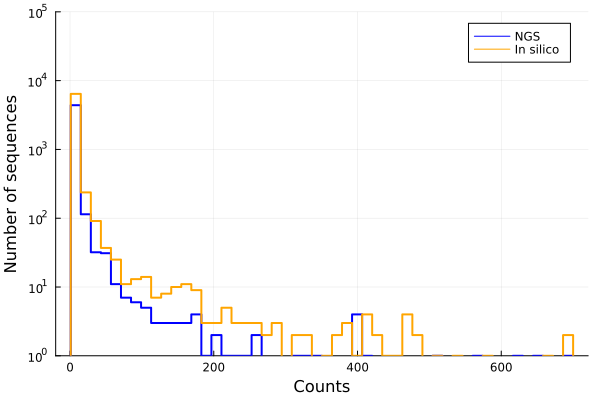

In [28]:
his_range = range(1, 700, length=51)
stephist(str4Analysis.Total_Count, yaxis=(:log10, (1, 100000)), bins = his_range, 
    ylabel="Number of sequences", xlabel="Counts", ma=0.2, lw=2, color=:blue, labels="NGS")
stephist!(str4Analysis_random.Total_Count, yaxis=(:log10, (1, 100000)), bins = his_range,
    ylabel="Number of sequences", lw=2, color=:orange, labels="In silico")

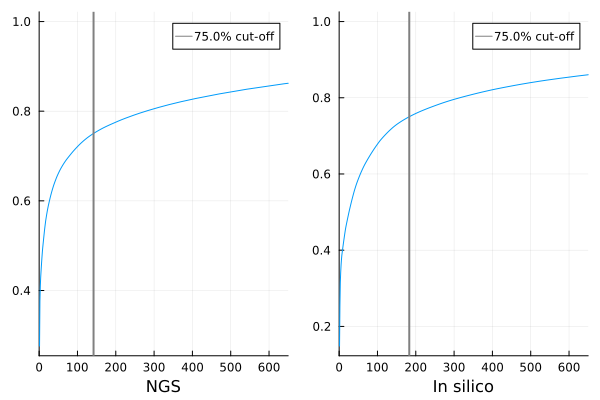

In [29]:
p1 = plot(plot_cdf, xaxis=[0,650], xlabel="NGS")
p2 = plot(plot_cdf_random, xaxis=[0,650], xlabel="In silico")
plot(p1, p2)

In [30]:
## Adding ranks to the data
rank_ngs = str4Analysis
rank_silico = str4Analysis_random

for n = 1:size(rank_ngs, 1)
    if n == 1
        rank_ngs.Str_number[n] = 1
    else
        if rank_ngs.Total_Count[n] == rank_ngs.Total_Count[n-1]
            rank_ngs.Str_number[n] = rank_ngs.Str_number[n-1]
        else
            rank_ngs.Str_number[n] = rank_ngs.Str_number[n-1]+1
        end
    end
end

for n = 1:size(rank_silico, 1)
    if n == 1
        rank_silico.Str_number[n] = 1
    else
        if rank_silico.Total_Count[n] == rank_silico.Total_Count[n-1]
            rank_silico.Str_number[n] = rank_silico.Str_number[n-1]
        else
            rank_silico.Str_number[n] = rank_silico.Str_number[n-1]+1
        end
    end
end

In [31]:
## Creating a set with the most frequent structures
frequentStructures = unique(vcat(str4Analysis.MFE_structure[1:cutoffStr], str4Analysis_random.MFE_structure[1:cutoffStr_random]))

## Creating a Dataframe to accomodate and compare the different structures
structureComparison = DataFrame([[],[],[],[],[],[]], ["MFE_structure", "NGS_count","NGS_rank", "Silico_count", "Silico_rank", "Str_Cluster"])
for n in frequentStructures
    
    ngs_count = filter(:MFE_structure => x -> x == n, str4Analysis)
    if size(ngs_count,1) > 0
        ngs_count = ngs_count.Total_Count[1]
    else
        ngs_count = 0
    end
    
    ngs_rank = filter(:MFE_structure =>x -> x == n, rank_ngs)
    if size(ngs_rank, 1) > 0
        ngs_rank = ngs_rank.Str_number[1]
    else
        ngs_rank = 0
    end
    
    silico_count = filter(:MFE_structure => x -> x == n, str4Analysis_random)
    if size(silico_count, 1) > 0
        silico_count = silico_count.Total_Count[1]
    else
        silico_count = 0
    end
    
    silico_rank = filter(:MFE_structure =>x -> x == n, rank_silico)
    if size(silico_rank, 1) > 0 
        silico_rank = silico_rank.Str_number[1]
    else 
        silico_rank = 0
    end
    
    new_entry = DataFrame([[n],[ngs_count],[ngs_rank],[silico_count],[silico_rank],[0]],["MFE_structure", "NGS_count","NGS_rank", "Silico_count", "Silico_rank", "Str_Cluster"])
    append!(structureComparison, new_entry)
end
;

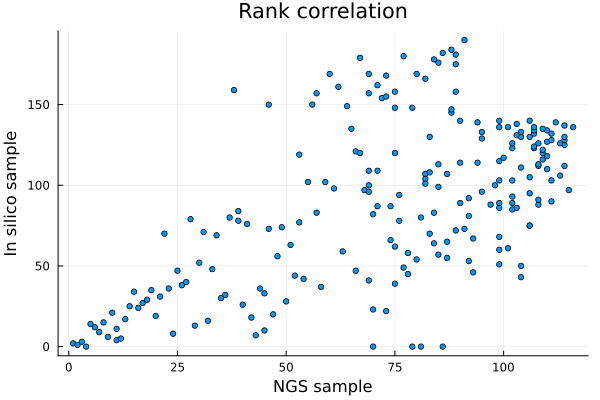

In [32]:
scatter(structureComparison.NGS_rank, structureComparison.Silico_rank, ms = 3,
    labels=false, title="Rank correlation",yaxis = "In silico sample", xaxis = "NGS sample")

In [33]:
sort!(structureComparison, :Silico_rank) 

Row,MFE_structure,NGS_count,NGS_rank,Silico_count,Silico_rank,Str_Cluster
,Any,Any,Any,Any,Any,Any
1,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((.................)).))).)))).........,948,4,0,0,0
2,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((............)).)).))).)))).........,50,70,0,0,0
3,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.((((((..............).)).))).)))).........,40,79,0,0,0
4,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((...((((((................))).)))...)).........,38,81,0,0,0
5,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.((((((((..........))).)).))).)))).........,31,86,0,0,0
6,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((..............)))).))).)))).........,4818,2,14842,1,0
7,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.((((((................))).))).)))).........,13269,1,10656,2,0
8,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.((((((((............))))).))).)))).........,1596,3,5980,3,0
9,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((((..........)))))).))).)))).........,404,11,2676,4,0


In [35]:
furtherAnalysis = filter(:NGS_rank => n -> n == 12, structureComparison)

Row,MFE_structure,NGS_count,NGS_rank,Silico_count,Silico_rank,Str_Cluster
,Any,Any,Any,Any,Any,Any
1,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.............)))).))).)))).........,399,12,1934,5,0


In [36]:
NGS_furtherAnalysis = filter(:MFE_structure => n -> n == furtherAnalysis.MFE_structure[1], libAnalysisClean)
silico_furtherAnalysis = filter(:MFE_structure => n -> n == furtherAnalysis.MFE_structure[1], sampledDataset)
;

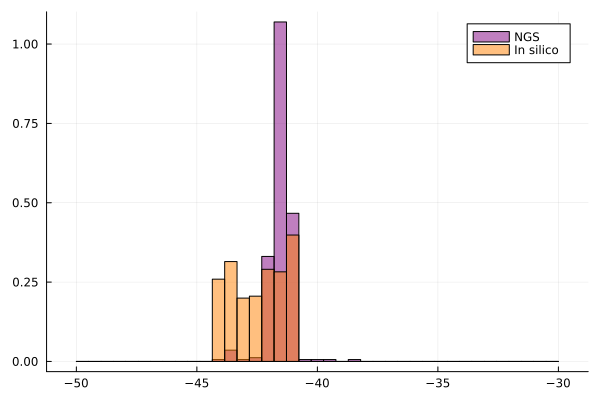

In [37]:
## Difference in MFE between NGS and in silico variants

his_range = range(-50, -30, length=40)
histogram(NGS_furtherAnalysis.MFE_energy, normalize=:pdf, bins=his_range, color=RGBA(0.5,0,0.5,0.5), labels="NGS")
histogram!(silico_furtherAnalysis.MFE_energy, normalize=:pdf, bins=his_range, color=RGBA(1,0.5,0,0.5), labels="In silico")


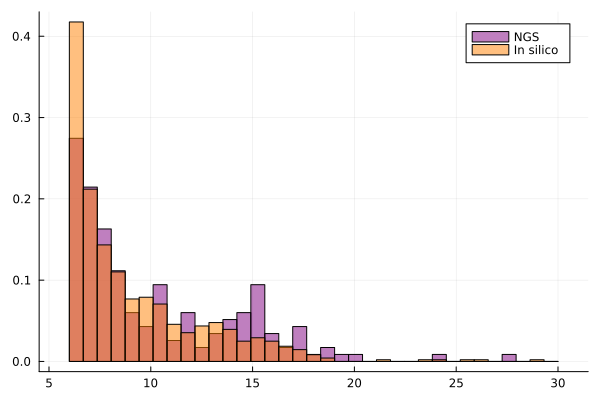

In [38]:
## Difference in Mbp_dist between NGS and in silico variants

his_range = range(6, 30, length=36)
histogram(NGS_furtherAnalysis.Mbp_dist, normalize=:pdf, bins=his_range, color=RGBA(0.5,0,0.5,0.5), labels="NGS")
histogram!(silico_furtherAnalysis.Mbp_dist, normalize=:pdf, bins=his_range, color=RGBA(1,0.5,0,0.5), labels="In silico")


In [39]:
## Loading the folding parameters for ViennaRNA
ViennaRNA.params_load_RNA_Langdon2018()

seq_size = size(structureComparison, 1) # for convenience
;

In [40]:
# This looks at the difference between minimum free energy structures - closest to structural Hamming distance.
Struc_diff = zeros(Float16, seq_size, seq_size)
for i = 1: seq_size
    for j = i: seq_size
        structure_Hamming = tree_edit_dist(structureComparison.MFE_structure[i], structureComparison.MFE_structure[j])      
        Struc_diff[i,j] = structure_Hamming
        Struc_diff[j,i] = structure_Hamming
    end
end

In [41]:
## Saving distance matrices for reclustering
save_name = "StructureDistance_2ndmethod_" * file_name[1:end-6] * ".csv"

writedlm(save_name, Struc_diff, ",")
#check readdlm(save_name, Struc_diff, ",")

In [64]:
# creates clusters from the data above - sequence
Cluster_struct2 = hclust(Struc_diff, linkage=:complete, uplo=:U, branchorder=:r)
cluster_cut_off2 = 20 # defines the minimum degree of similarity within a cluster
structureComparison.Str_Cluster = Int16.(cutree(Cluster_struct2; h=cluster_cut_off2)) #k: number of clusters, h: maximum distance
;

In [65]:
structureComparison

Row,MFE_structure,NGS_count,NGS_rank,Silico_count,Silico_rank,Str_Cluster
,Any,Any,Any,Any,Any,Int16
1,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((.................)).))).)))).........,948,4,0,0,1
2,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((............)).)).))).)))).........,50,70,0,0,2
3,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.((((((..............).)).))).)))).........,40,79,0,0,1
4,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((...((((((................))).)))...)).........,38,81,0,0,1
5,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.((((((((..........))).)).))).)))).........,31,86,0,0,2
6,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((..............)))).))).)))).........,4818,2,14842,1,2
7,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.((((((................))).))).)))).........,13269,1,10656,2,1
8,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.((((((((............))))).))).)))).........,1596,3,5980,3,2
9,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((((..........)))))).))).)))).........,404,11,2676,4,3


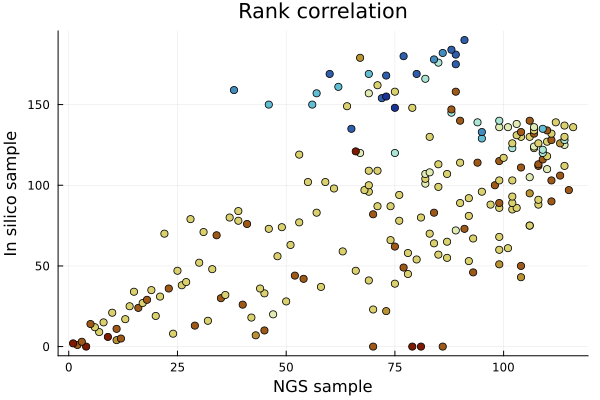

In [66]:
clusters = unique(structureComparison.Str_Cluster)
colorList = cgrad(:roma, size(clusters,1), categorical = true)

## Plotting all clusters
scatter(structureComparison.NGS_rank, structureComparison.Silico_rank, ms = 4,
    labels=false, title="Rank correlation",yaxis = "In silico sample", xaxis = "NGS sample", color=colorList[structureComparison.Str_Cluster])

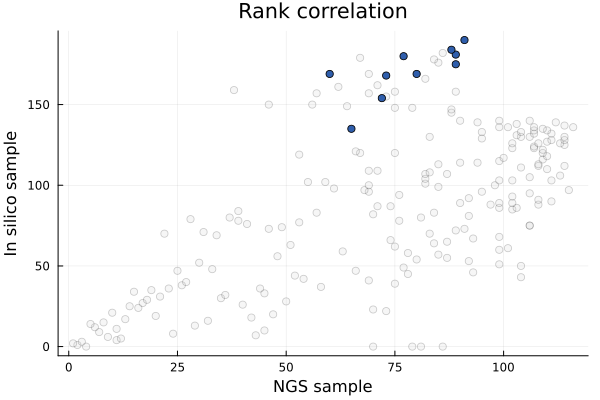

In [68]:
## Plotting individual clusters
cluster2see = 9

data2graph = filter(:Str_Cluster => n -> n == cluster2see, structureComparison)
scatter(structureComparison.NGS_rank, structureComparison.Silico_rank, ms = 4,
    labels=false, title="Rank correlation",yaxis = "In silico sample", xaxis = "NGS sample",
    color=:lightgrey, ma=0.2)
scatter!(data2graph.NGS_rank, data2graph.Silico_rank, ms = 4,
    labels=false, title="Rank correlation",yaxis = "In silico sample", xaxis = "NGS sample",
    color=colorList[cluster2see])